<a href="https://colab.research.google.com/github/Nlioxa/ml-labs/blob/main/ml_lab1_korzun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practise #1. Gaining familiarity with TensorFlow framework through the image processing
---

## Prerequisites

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from urllib.request import urlopen
from ipywidgets import interact

In [2]:
def load_image(
    url: str, 
    dtype = tf.float32
) -> tf.Tensor:
  """
  Loads image from the given URL
  returns: Tensor of 4 dimensions [N,H,W,C]
  """
  request = urlopen(url)
  raw_data = request.read()
  image = tf.io.decode_image(
      raw_data, 
      dtype = dtype
      )
  
  return image[tf.newaxis]

In [3]:
def display_image(
    *results,
    **args
):
  """
  Displays images given as (title, image) tuples in a row
  """
  figure = plt.figure(figsize = args.get('figsize', (5 * len(results), 5)))
  subs = figure.subplots(1, len(results))
  if len(results) == 1: subs = [subs]
  for i, result in enumerate(results):
    subs[i].axis('off')
    if len(results) > 1:
      (image, title) = result
      subs[i].set_title(title)
      subs[i].imshow(image[0])
    else:
      subs[i].imshow(result[0])
  plt.show()

In [4]:
def conv(
    image: tf.Tensor, 
    filter,
    strides = None,
    padding = 'VALID'
):
  if strides is None:
    strides = [1 for i in range(len(image.shape))]
  filter = tf.tile(filter[..., tf.newaxis], [1, 1, 3])
  filter = filter[..., tf.newaxis]
  return tf.nn.depthwise_conv2d(image, filter, strides, padding, data_format='NHWC')

## 1. Image brightness adjustment

In [5]:
image = load_image('http://photoshopdesire.com/wp-content/uploads/2017/09/Before-How-to-Change-Bad-Light-Photos-to-Amazing-Low-key-Portrait-in-Photoshop.jpg')
image_hsv = tf.image.rgb_to_hsv(image)

### # linear method


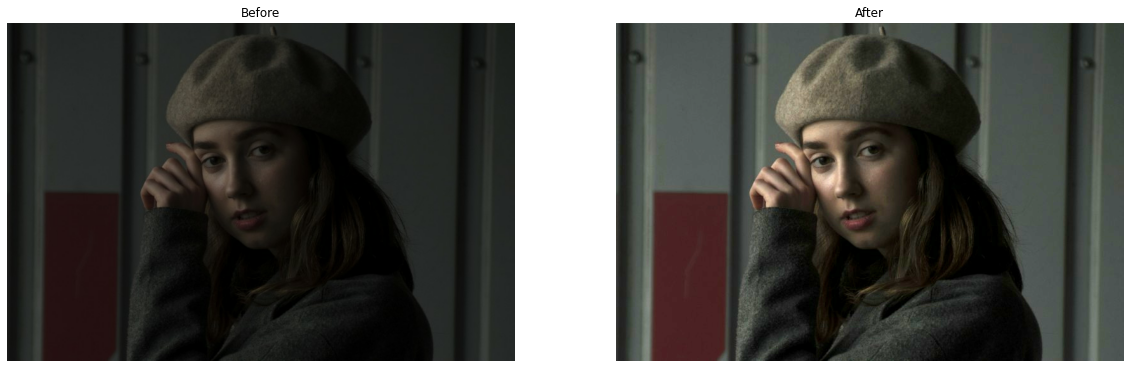

In [6]:
img_hsv = image_hsv

# calculate adjusted image
Imin = tf.reduce_min(img_hsv[...,-1])
Imax = tf.reduce_max(img_hsv[...,-1])
Idel = Imax - Imin

adjusted = tf.map_fn(
    lambda I: (I - Imin) / Idel, 
    elems = img_hsv[...,-1])

img_hsv = tf.concat([img_hsv[..., :-1], adjusted[..., tf.newaxis]], axis=-1)
img_adj = tf.image.hsv_to_rgb(img_hsv)

display_image((image, 'Before'), (img_adj, 'After'), figsize = (20, 10))

### # exponential method

In [7]:
@interact
def exponential_adjustment(
    gamma = (0.5, 1, 0.01)
):
  img_hsv = image_hsv

  # calculate adjusted image
  adjusted = tf.map_fn(
      lambda I: 255 * (I / 255)**gamma,
      elems = img_hsv[...,-1])

  img_hsv = tf.concat([img_hsv[..., :-1], adjusted[..., tf.newaxis]], axis=-1)
  img_adj = tf.image.hsv_to_rgb(img_hsv)

  display_image((image, 'Before'), (img_adj, 'After'), figsize = (20, 10))

interactive(children=(FloatSlider(value=0.75, description='gamma', max=1.0, min=0.5, step=0.01), Output()), _d…

## 2. Image filtering

In [8]:
image = load_image('https://www.apogeephoto.com/wp-content/uploads/2016/06/a2-3.jpg')

### # Gaussian filter

In [9]:
@interact
def gaussian_filtering (
    kernel_size = (1, 20, 1),
    sigma = (1, 100, 0.01)
):
  def gaussian(
      kernel_size: int, 
      sigma: float
    ) -> tf.Tensor:
    ax = abs(tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0))
    xx, yy = tf.meshgrid(ax, ax)
    mx = xx + yy
    kernel = tf.exp(-(mx**2) / (2.0 * (sigma**2)))
    kernel = kernel / tf.reduce_sum(kernel)
    return kernel
  
  # calculate filtered image
  kernel = gaussian(kernel_size, sigma)
  filtered = conv(image, kernel)
  
  display_image((image, 'Before'), (filtered, 'After'), figsize = (20, 10))

interactive(children=(IntSlider(value=10, description='kernel_size', max=20, min=1), FloatSlider(value=50.0, d…

### # Box filter

In [10]:
@interact
def box_filtering(
  kernel_size = (1, 20, 1)
):
  # calculate filtered image
  kernel = tf.ones((kernel_size, kernel_size)) / kernel_size**2
  filtered = conv(image, kernel)
  
  display_image((image, 'Before'), (filtered, 'After'), figsize = (20, 10))

interactive(children=(IntSlider(value=10, description='kernel_size', max=20, min=1), Output()), _dom_classes=(…

### # Unsharp masking


In [11]:
@interact
def box_filtering(
  lam = (0, 10, 1)
):
  # calculate filtered image
  kernel = tf.constant([
          [0, -1, 0],
          [-1, 4, -1],
          [0, -1, 0]
      ]) * lam + tf.constant([
          [0, 0, 0],
          [0, 1, 0],
          [0, 0, 0]
      ])

  kernel = tf.cast(kernel, dtype=tf.float32)
  filtered = conv(image, kernel)
  
  display_image((image, 'Before'), (filtered, 'After'), figsize = (20, 10))

interactive(children=(IntSlider(value=5, description='lam', max=10), Output()), _dom_classes=('widget-interact…

## 3. Sobel edge detection

In [17]:
image = load_image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/NASA_Mars_Rover.jpg/1200px-NASA_Mars_Rover.jpg')

### # Regular Sobel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


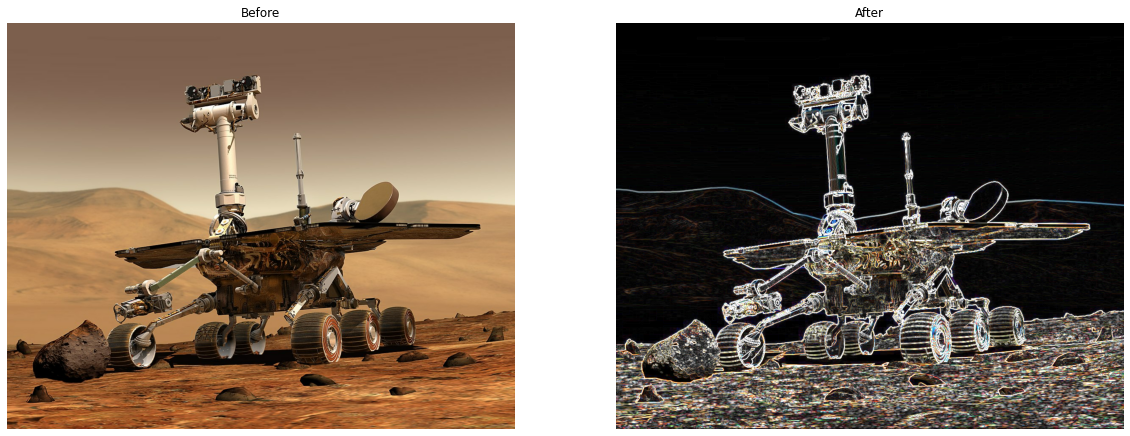

In [26]:
# compute sobel edges
sobel = tf.image.sobel_edges(image)
sobel_edges = tf.sqrt(tf.reduce_sum(sobel[0]**2, axis=-1))[tf.newaxis]

display_image((image, 'Before'), (sobel_edges, 'After'), figsize = (20, 10))